Read in the data

In [54]:
import pandas as pd
import numpy as np

train = pd.read_csv('input/train.csv', 
                    index_col='id', 
                    parse_dates=['project_submitted_datetime'])
resources = pd.read_csv('input/resources.csv', index_col='id')

# Data Exploration

## Prior submissions

How does total submissions effect acceptance rate?

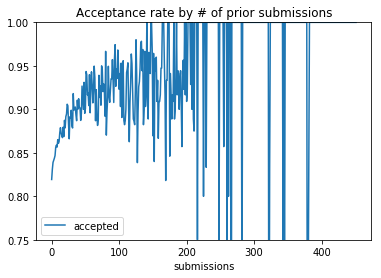

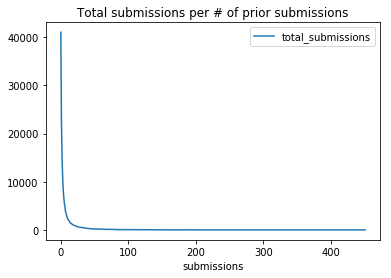

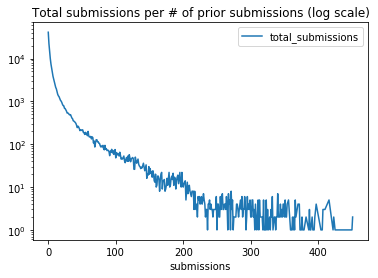

In [55]:
import matplotlib.pyplot as plt

prior_submit = train['teacher_number_of_previously_posted_projects']
accepted = train['project_is_approved']
submit_accepted = pd.DataFrame({'submissions': prior_submit, 'accepted': accepted})
grouped_submissions = submit_accepted.sort_values('submissions').groupby('submissions')
accept_rate = grouped_submissions.mean()
accept_rate['total_submissions'] = grouped_submissions.sum()

accept_rate.plot(y='accepted',
                 title='Acceptance rate by # of prior submissions',
                 ylim=[0.75,1])
accept_rate.plot(y='total_submissions',
                 title='Total submissions per # of prior submissions')
accept_rate.plot(y='total_submissions',
                 title='Total submissions per # of prior submissions (log scale)',
                 logy=True)

There is a clear increase in acceptance rate from teachers with prior submissions, until the data becomes noisy due to low submission rates above 50 prior submissions.

In general, teachers with more prior submissions are more likely to have their submission accepted. The data becomes noisy at high number of prior submissions because very few submissions have more than 200 prior submissions. Binning the data can help deal with this noise.

[  0.   1.   4.  12. 451.]


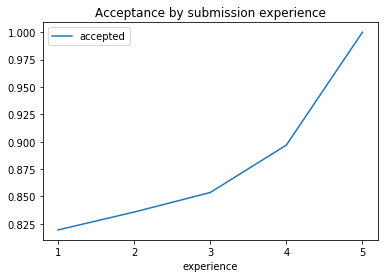

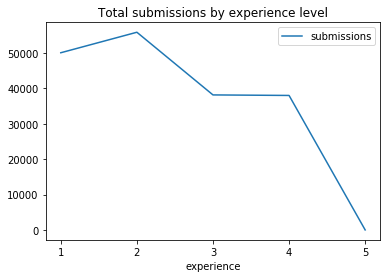

In [56]:
# Create equal sized bins, and digitize into experience levels
bins = pd.qcut(x=submit_accepted['submissions'], 
               q=5, 
               duplicates='drop', 
               retbins=True)[1]
print(bins)
submit_accepted['experience'] = np.digitize(submit_accepted['submissions'], bins)

# Calculate acceptance rate per experience level
grouped_submissions = submit_accepted.drop('submissions', axis=1).sort_values('experience').groupby('experience')
accept_rate = grouped_submissions.mean()
accept_rate['submissions'] = grouped_submissions.count()
accept_rate.plot(y='accepted',
                 xticks=range(1, len(accept_rate.index)+1),
                 title="Acceptance by submission experience")
accept_rate.plot(y='submissions',
                 xticks=range(1, len(accept_rate.index)+1),
                 title='Total submissions by experience level')

These bins provide a relatively equal distribution of total submissions per experience level, while demonstrating a clear correlation between experience and acceptance rate. This would make a good feature. The previous feature containing the exact number of submissions is dropped to maintain linear independence between features.

In [57]:
train['experience'] = np.digitize(train['teacher_number_of_previously_posted_projects'], bins)
train = train.drop('teacher_number_of_previously_posted_projects', axis=1)

# Data Preprocessing

For now, all unique strings will be discarded as they can't be effectively input. Later these will be analyzed. All remaining data is then one-hot encoded.

In [58]:
y = train['project_is_approved']

# Drop categories that can't currently be processed
drop_cats = ['project_is_approved', 'teacher_id','project_submitted_datetime','project_title','project_essay_1','project_essay_2','project_essay_3','project_essay_4','project_resource_summary', 'project_subject_categories','project_subject_subcategories']
X = train.drop(drop_cats, axis=1)

#One-hot encode the rest
encode_cats = ['teacher_prefix', 'school_state', 'project_grade_category', 'experience']
for cat in encode_cats:
    hot = pd.get_dummies(X[cat])
    X = X.drop(cat, axis=1)
    X = X.join(hot)

# Learning

A Random Forest Classifier is used with cross validation to find the accuracy of the current model

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rfc = RandomForestClassifier()
res = cross_val_score(rfc, X, y, cv=5, n_jobs=-1)
print("Average accuracy: ", res.mean())

Average accuracy:  0.8464301426625866
